In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Devkit

Please refer to [the OpenLane-V2 devkit](https://github.com/OpenDriveLab/OpenLane-V2/blob/master/docs/devkit.md) for a detailed description of the API.

In [2]:
root_path = './data/OpenLane-V2'

## Preprocessing

Collect meta data of a collection of data and store it into a pickle file, where the collection can be user-defined by modifying the input data_dict. Note that for evaluation, we subsample the number of points of lane centerlines with an interval of 20. For training, the `point_interval` can be set to 1 to disable subsampling.

To preprocess the whole dataset, please refer to [preprocess](https://github.com/OpenDriveLab/OpenLane-V2/blob/master/data/README.md#preprocess).

In [3]:
from openlanev2.io import io
from openlanev2.preprocessing import collect

data_dict = io.json_load(f'{root_path}/data_dict_sample.json')
collect(root_path, data_dict, 'data_dict_sample', point_interval=20)

collecting data_dict_sample: 100%|██████████████| 64/64 [00:01<00:00, 43.61it/s]


---

## Dataset

Load meta data from the generated pickle file.
A frame can be fetched by specifying the identifier `(split, segment_id, timestamp)` or giving the index of the data in the collection.

In [4]:
from openlanev2.dataset import Collection, Frame

collection = Collection(root_path, root_path, 'data_dict_sample')
frame = collection.get_frame_via_identifier(('train', '00492', '315970276749927222'))

The pose of the ego vehicle can be obtained by `get_pose()`.

In [5]:
for k, v in frame.get_pose().items():
    print(k, '\n', v, '\n')

rotation 
 [[-0.03161852  0.99932457  0.01872611]
 [-0.99904989 -0.03103652 -0.0305949 ]
 [-0.02999304 -0.01967568  0.99935644]] 

translation 
 [6657.19639943 1842.86566032   59.89421563] 



Each frame contains multi-view images covering the whole horizontal FOV.

In [6]:
for k in frame.get_camera_list():
    print(k)

ring_front_center
ring_front_left
ring_front_right
ring_rear_left
ring_rear_right
ring_side_left
ring_side_right


For each image, we provide intrinsic and extrinsic matrices of the camera.

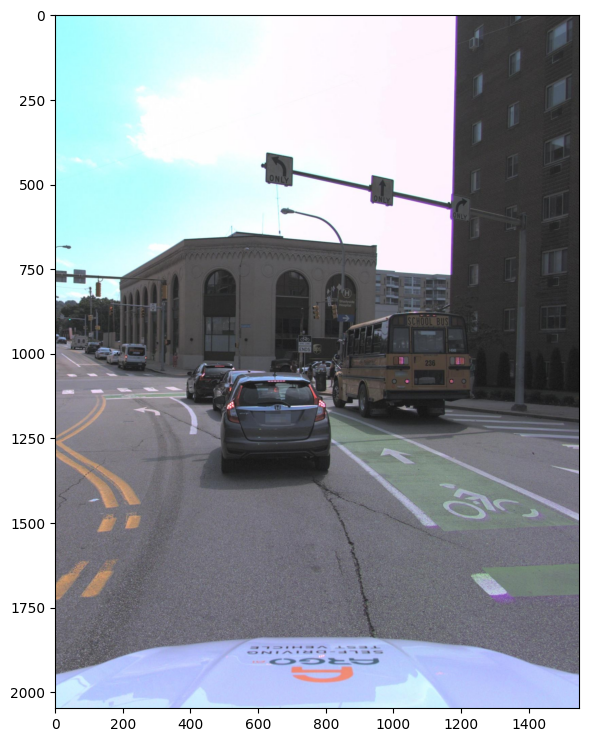

intrinsic - K 
 [[1.77753967e+03 0.00000000e+00 7.77762878e+02]
 [0.00000000e+00 1.77753967e+03 1.01631311e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] 

intrinsic - distortion 
 [-0.24479243 -0.19577468  0.30131747] 

extrinsic - rotation 
 [[-8.48589870e-04  1.00005773e-02  9.99949633e-01]
 [-9.99998983e-01 -1.15429954e-03 -8.37087508e-04]
 [ 1.14587004e-03 -9.99949327e-01  1.00015467e-02]] 

extrinsic - translation 
 [1.63315125 0.00800013 1.38385219] 



In [7]:
camera = frame.get_camera_list()[0]

image = frame.get_rgb_image(camera)

plt.figure(figsize=[16, 9])
plt.imshow(image)
plt.show()

meta = {
    'intrinsic': frame.get_intrinsic(camera),
    'extrinsic': frame.get_extrinsic(camera),
}
for key, value in meta.items():
    for k, v in value.items():
        print(key, '-', k, '\n', v, '\n')

Annotations of a frame can be loaded separately.

In [8]:
annotations = frame.get_annotations()
print(list(annotations.keys()))

for a, anno in zip(
    annotations.keys(), 
    [
        frame.get_annotations_lane_centerlines()[0],
        frame.get_annotations_traffic_elements()[0],
        frame.get_annotations_topology_lclc(),
        frame.get_annotations_topology_lcte(),
    ]):
    print(f'\n{a}:')
    if isinstance(anno, dict):
        for k, v in anno.items():
            print(k, v.shape) if isinstance(v, np.ndarray) else print(k, type(v))
    else:
        print('adjacent matrix', anno.shape)

['lane_centerline', 'traffic_element', 'topology_lclc', 'topology_lcte']

lane_centerline:
id <class 'str'>
points (11, 3)
is_intersection_or_connector <class 'bool'>

traffic_element:
id <class 'str'>
category <class 'int'>
attribute <class 'int'>
points (2, 2)

topology_lclc:
adjacent matrix (61, 61)

topology_lcte:
adjacent matrix (61, 11)


---

## Visualization

Preprocess the annotations for visualization.

In [9]:
from openlanev2.visualization import draw_annotation_bev, draw_annotation_pv, assign_attribute, assign_topology

annotations = assign_attribute(annotations)
annotations = assign_topology(annotations)

Visualize annotations in the bird's-eye view. `with_attribute` denotes that color is used to draw lane centerlines, which indicates the attribute of the lane centerline, or not.

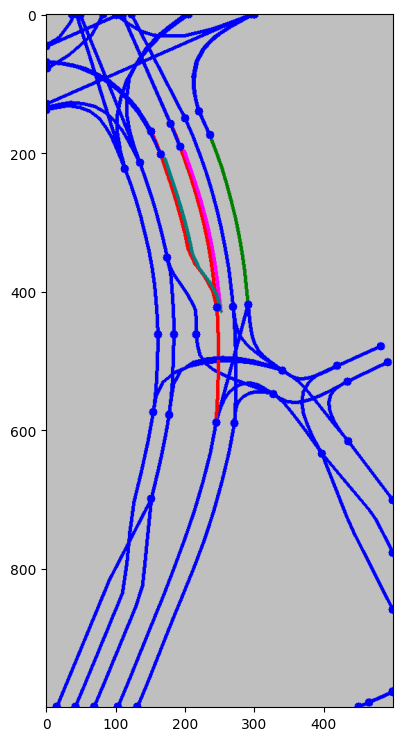

In [10]:
image_bev = draw_annotation_bev(
    annotations, 
    with_attribute=True,
)

plt.figure(figsize=[16, 9])
plt.imshow(image_bev)
plt.show()

Visualize annotations in the perspective view. Note that as traffic elements are annotated in the front-view image, visualization for traffic elements and the topology is only valid in the front-view image.

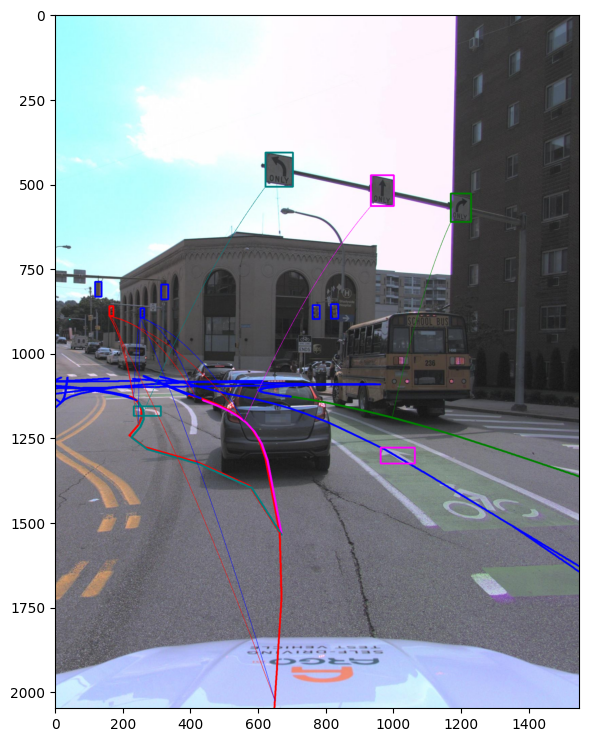

In [11]:
image_pv = draw_annotation_pv(
    camera, 
    image.copy(), 
    annotations,
    meta['intrinsic'],
    meta['extrinsic'],
    with_attribute=True, 
    with_topology=True,
)

plt.figure(figsize=[16, 9])
plt.imshow(image_pv)
plt.show()

---

## Evaluation

We provide tools for evaluation based on the generated pickle files.
The input can be a path to the pickle or a formatted dictionary.

In [12]:
from openlanev2.evaluation import evaluate
from openlanev2.utils import format_metric

format_metric(evaluate(ground_truth=f'{root_path}/data_dict_sample.pkl', predictions=None))


Dummy evaluation on ground truth.



calculating distances:: 100%|███████████████████| 64/64 [00:17<00:00,  3.69it/s]


OpenLane-V2 Score - 1.0
    DET_l - 1.0
    DET_t - 1.0
    TOP_ll - 1.0
    TOP_lt - 1.0
F-Score for 3D Lane - 1.0


To construct results for evaluation, please follow the example below.
Some keys are necessary for a valid evaluation.
Note that `openlanev2.preprocessing.check_results` conducting checking on prediction format in the `evaluate` function.

In [13]:
results = {
    'method': 'dummy',
    'e-mail': 'dummy@openlanev2',
    'institution / company': 'dummy',
    'results': {},
}
for key in collection.keys:
    results['results'][key] = {
        'predictions': {
            'lane_centerline': [{
                'id': 20,
                'points': np.asarray([
                    [1, 2, 3],
                    [2, 3, 4],
                ]),
                'confidence': 0.6,
            }],
            'traffic_element': [{
                'id': i,
                'category': 0,
                'attribute': i,
                'points': np.asarray([
                    [1, 2],
                    [3, 4],
                ]),
                'confidence': 0.7,
            } for i in range(13)],
            'topology_lclc': np.asarray([
                [0],
            ]),
            'topology_lcte': np.asarray([
                [0.8 for _ in range(13)],
            ]),
        }
    }

results = evaluate(
    ground_truth=f'{root_path}/data_dict_sample.pkl', 
    predictions=results,
)


*** Missing key [country / region] for a valid submission ***


*** Missing key [authors] for a valid submission ***



calculating distances:: 100%|███████████████████| 64/64 [00:01<00:00, 59.32it/s]


---

# Train a Model

To train your first model on OpenLane-V2, please checkout to [plug-ins](https://github.com/OpenDriveLab/OpenLane-V2#train-a-model) for the provided baseline model in prevailing training frameworks. We currently provide a plug-in to [mmdet3d](https://github.com/open-mmlab/mmdetection3d), in which a pipeline for training, evaluation, visualization, and formatting submission files is built.

Your joint contribution to maintaining or adding new plug-ins to other frameworks is welcomed.